In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [15]:
# Step 1: Load Dataset
path = "C:/Users/farru/Desktop/NEU_Q4/EAI 6010/Week 2/season_dataset"

# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transform for Validation and Testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset
train_dataset = datasets.ImageFolder(root=path, transform=train_transform)
val_test_dataset = datasets.ImageFolder(root=path, transform=val_test_transform)

# Get Class Names
class_names = train_dataset.classes
print("Class names:", class_names)


Class names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [16]:
# Step 2: Split Dataset
train_size = int(0.7 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Sample Images from Dataset:


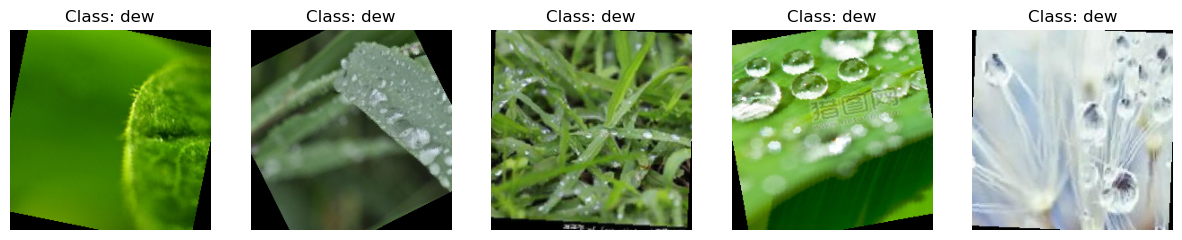

In [17]:
# Step 3: Display Sample Images from Dataset
def show_sample_images(dataset, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Class: {class_names[label]}")
        plt.axis("off")
    plt.show()

print("Sample Images from Dataset:")
show_sample_images(train_dataset, class_names)

In [18]:
# Step 4: Define Model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # Adjust for number of classes
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [19]:
# Step 5: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Learning rate scheduler

In [20]:
# Step 6: Train Model with Visualization
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience = 3
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

        # Update learning rate
        scheduler.step()

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()
    return model

In [21]:
def evaluate_model(model, data_loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    loss = running_loss / len(data_loader) if criterion else None
    return loss, accuracy


Epoch 1, Train Loss: 1.2434, Train Accuracy: 60.38%, Val Loss: 1.1918, Val Accuracy: 58.31%
Epoch 2, Train Loss: 0.9357, Train Accuracy: 69.50%, Val Loss: 1.1250, Val Accuracy: 64.33%
Epoch 3, Train Loss: 0.8532, Train Accuracy: 71.83%, Val Loss: 0.8267, Val Accuracy: 73.96%
Epoch 4, Train Loss: 0.6336, Train Accuracy: 79.80%, Val Loss: 0.5181, Val Accuracy: 83.19%
Epoch 5, Train Loss: 0.5165, Train Accuracy: 82.99%, Val Loss: 0.4609, Val Accuracy: 85.52%
Epoch 6, Train Loss: 0.4980, Train Accuracy: 83.64%, Val Loss: 0.4992, Val Accuracy: 82.60%
Epoch 7, Train Loss: 0.4558, Train Accuracy: 85.18%, Val Loss: 0.4515, Val Accuracy: 83.87%
Epoch 8, Train Loss: 0.4483, Train Accuracy: 85.09%, Val Loss: 0.4480, Val Accuracy: 84.35%
Epoch 9, Train Loss: 0.4645, Train Accuracy: 84.24%, Val Loss: 0.4302, Val Accuracy: 84.55%
Epoch 10, Train Loss: 0.4393, Train Accuracy: 85.55%, Val Loss: 0.4471, Val Accuracy: 83.87%


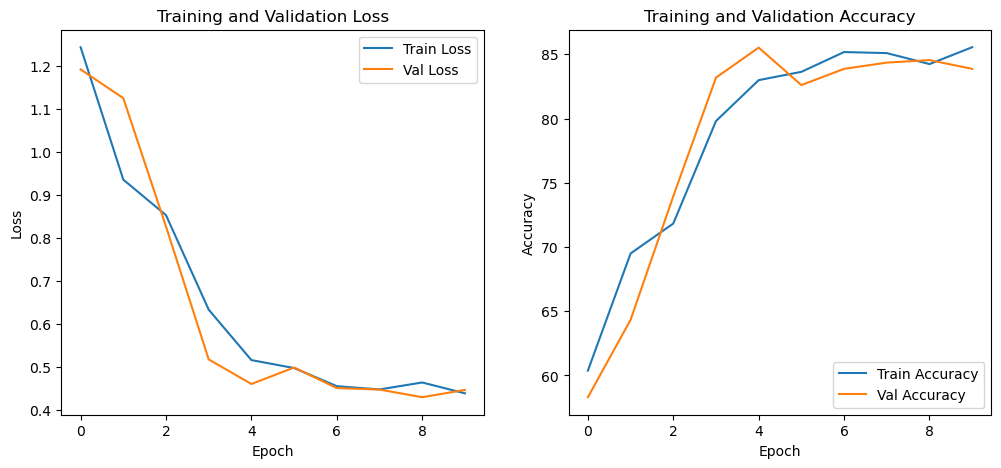

In [22]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)

In [23]:
# Step 7: Save Model
torch.save(trained_model.state_dict(), "weather_modelF.pth")


In [24]:
# Step 8: Model Evaluation
test_loss, test_accuracy = evaluate_model(trained_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.4360, Test Accuracy: 85.83%


Sample Predictions:


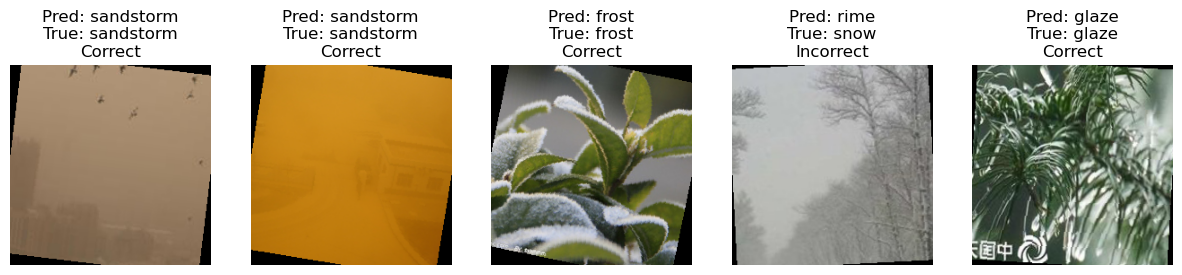

In [25]:
# Step 9: Test on Sample Images with Predictions
def test_on_samples(model, test_loader, class_names, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.imshow(img)
        is_correct = "Correct" if predicted[i] == labels[i] else "Incorrect"
        plt.title(f"Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}\n{is_correct}")
        plt.axis("off")
    plt.show()

print("Sample Predictions:")
test_on_samples(trained_model, test_loader, class_names)

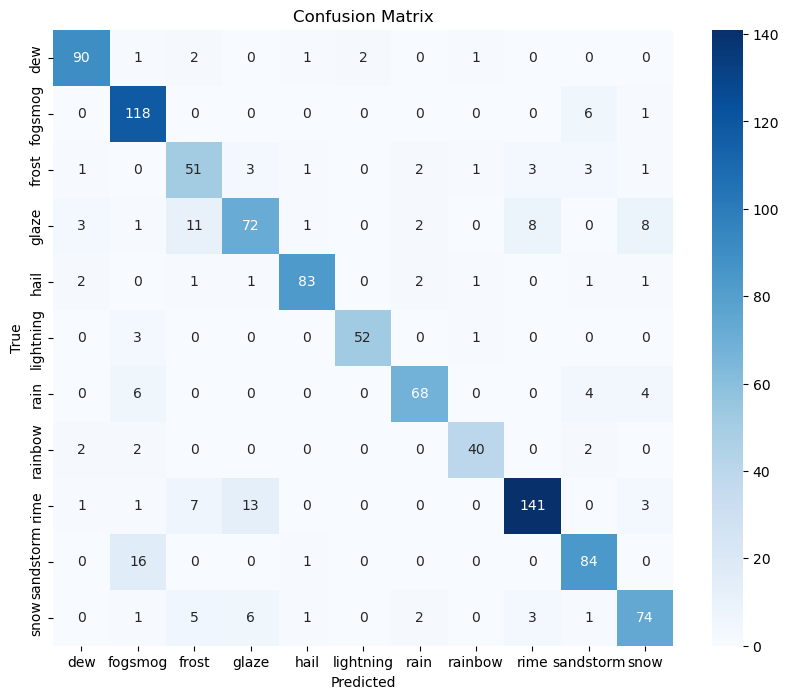

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(trained_model, test_loader, class_names)